# Realizando Simulações com os Modelos Criados: Dados de Teste

In [177]:
import os
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_ks_statistic

from sklearn.metrics import (
    classification_report,
    recall_score,
    precision_score,
    f1_score
)

from yellowbrick.classifier import (
    ClassPredictionError,
    ConfusionMatrix,
    ClassificationReport,
    ROCAUC
)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Carregando os dados

In [4]:
df_test = pd.read_parquet(
    os.environ['NOTEBOOKS_PROCESSED_DATA_PATH'] + \
        'creditcard_test.parquet'
)

df_test.shape

(56962, 31)

In [5]:
X_test = df_test.drop('Fraude', axis=1).values
y_test = df_test['Fraude'].values

In [6]:
df_train = pd.read_parquet(
    os.environ['NOTEBOOKS_PROCESSED_DATA_PATH'] + \
        'creditcard_train_major.parquet'
)

df_train.shape

(227845, 31)

In [7]:
X_train = df_train.drop('Fraude', axis=1).values
y_train = df_train['Fraude'].values

## Carregando os modelos

In [8]:
os.listdir(os.environ['NOTEBOOKS_MODELS_PATH'])

['DummyClassifier_fraud_detection.sav',
 'lgbm_fraud_detection.sav',
 'QuadraticDiscriminantAnalysis_fraud_detection.sav',
 'xgb_fraud_detection.sav',
 'xgb_fraud_detection_train.sav']

### Modelo principal

In [9]:
xgb = joblib.load(
    os.environ['NOTEBOOKS_MODELS_PATH'] + \
        'xgb_fraud_detection.sav'
)

xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

### Modelo *Benchmark*

In [10]:
bench = joblib.load(
    os.environ['NOTEBOOKS_MODELS_PATH'] + \
        'QuadraticDiscriminantAnalysis_fraud_detection.sav'
)

bench

QuadraticDiscriminantAnalysis()

### Modelo *Baseline*

In [11]:
dummy = joblib.load(
    os.environ['NOTEBOOKS_MODELS_PATH'] + \
        'DummyClassifier_fraud_detection.sav'
)

dummy

DummyClassifier(random_state=42, strategy='stratified')

### Outros

In [12]:
lgbm = joblib.load(
    os.environ['NOTEBOOKS_MODELS_PATH'] + \
        'lgbm_fraud_detection.sav'
)

lgbm

LGBMClassifier()

## Simulação com os modelos: dados de teste

### Avaliando as métricas dos modelos na simulação

In [13]:
models = {
    f'{xgb.__class__.__name__} Main': xgb,
    f'{bench.__class__.__name__} Bench': bench,
    f'{dummy.__class__.__name__} Base': dummy,
    f'{lgbm.__class__.__name__}': lgbm
}

In [20]:
reports = []

for model_name, model in models.items():
    y_pred = model.predict(X_test)

    report = pd.DataFrame({
        'Model': [model_name],
        'Recall 0': [recall_score(y_test, y_pred, pos_label=0)],
        'Recall 1': [recall_score(y_test, y_pred, pos_label=1)],
        'Precision 0': [precision_score(y_test, y_pred, pos_label=0)],
        'Precision 1': [precision_score(y_test, y_pred, pos_label=1)]
    })

    reports.append(report)

reports = pd.concat(reports, axis=0)
reports

,Model,Recall 0,Recall 1,Precision 0,Precision 1
0,XGBClassifier Main,1.000000,0.946667,0.999930,1.000000
0,QuadraticDiscriminantAnalysis Bench,0.982298,0.826667,0.999767,0.057998
0,DummyClassifier Base,0.998242,0.000000,0.998681,0.000000
0,LGBMClassifier,0.999666,0.013333,0.998700,0.050000


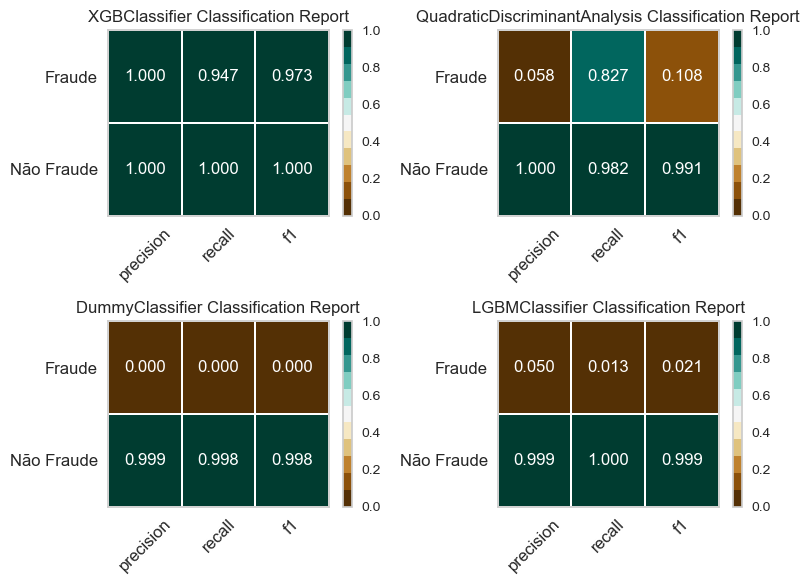

In [15]:
fig, ax = plt.subplots(2,2, figsize=(8,6));
ax = ax.flatten()

for i, (model_name, model) in enumerate(models.items()):
        visualizer = ClassificationReport(
            model,
            classes=['Não Fraude', 'Fraude'],
            cmap='BrBG',
            ax=ax[i]
        )

        visualizer.score(X_test, y_test)
        g = visualizer.finalize()

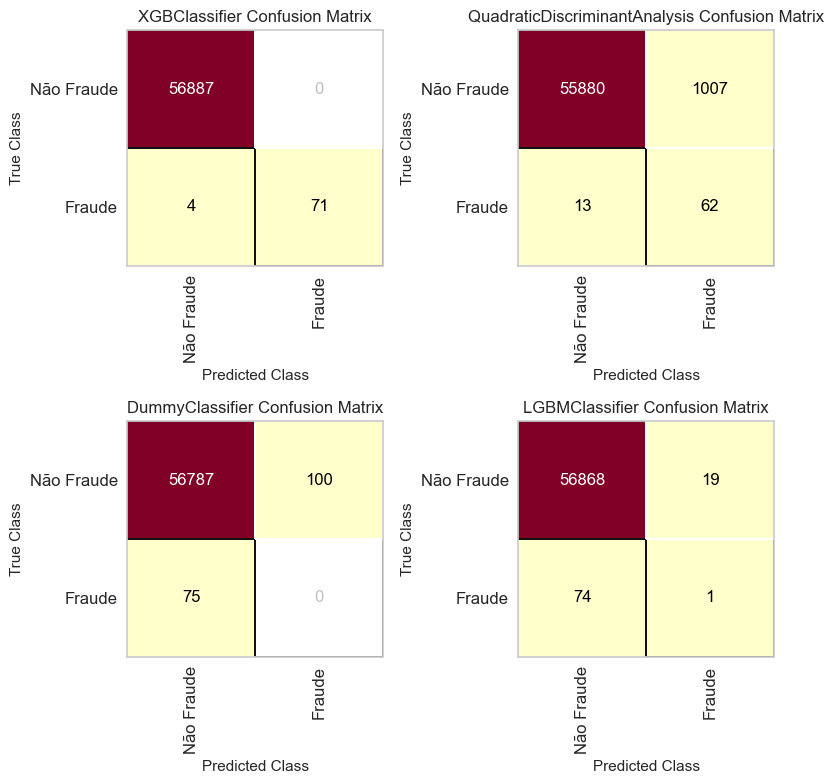

In [16]:
fig, ax = plt.subplots(2,2, figsize=(8,8));
ax = ax.flatten()

for i, (model_name, model) in enumerate(models.items()):
        visualizer = ConfusionMatrix(
            model,
            classes=['Não Fraude', 'Fraude'],
            ax=ax[i]
        )

        visualizer.score(X_test, y_test)
        g = visualizer.finalize()

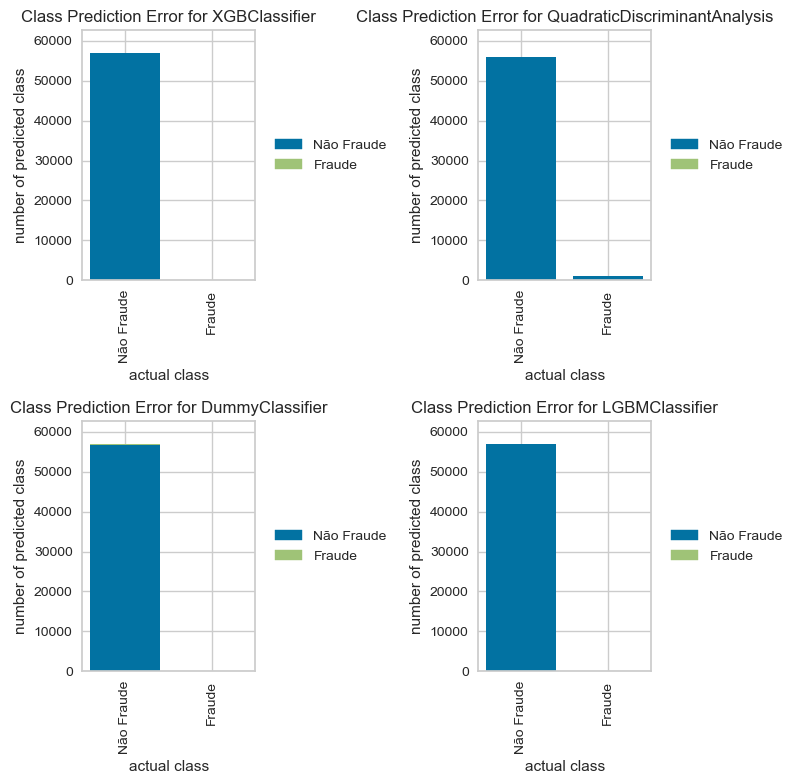

In [17]:
fig, ax = plt.subplots(2,2, figsize=(9,8));
ax = ax.flatten()

for i, (model_name, model) in enumerate(models.items()):
        visualizer = ClassPredictionError(
            model,
            classes=['Não Fraude', 'Fraude'],
            ax=ax[i]
        )

        visualizer.score(X_test, y_test)
        g = visualizer.finalize()

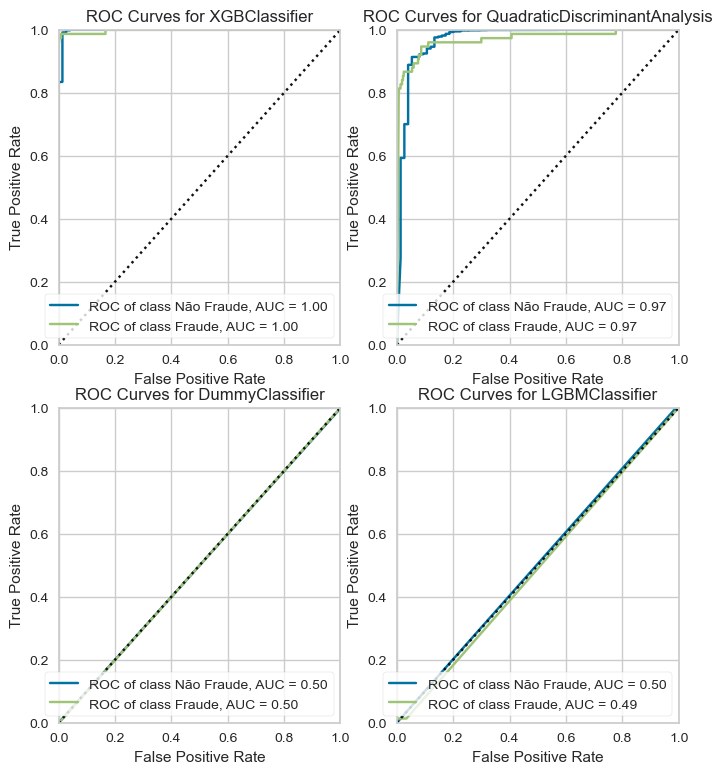

In [18]:
fig, ax = plt.subplots(2,2, figsize=(8,9));
ax = ax.flatten()

for i, (model_name, model) in enumerate(models.items()):
        visualizer = ROCAUC(
            model,
            iso_f1_curves=True,
            micro=False,
            macro=False,
            classes=['Não Fraude', 'Fraude'],
            ax=ax[i]
        )

        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        g = visualizer.finalize()

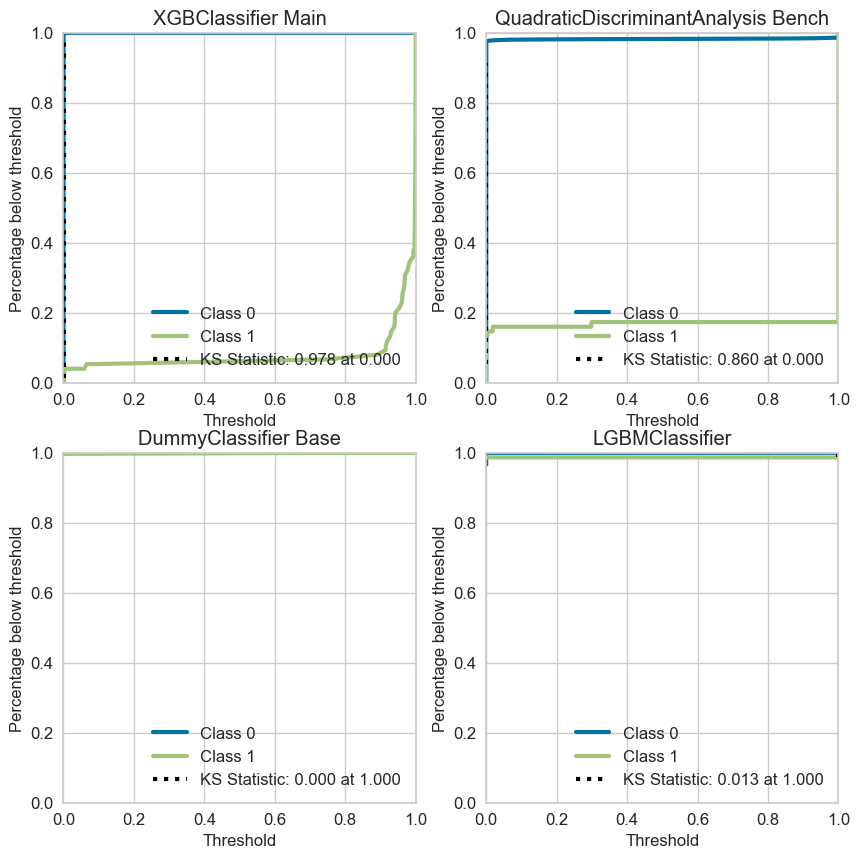

In [19]:
fig, ax = plt.subplots(2,2, figsize=(10,10));
ax = ax.flatten()

for i, (model_name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_test)
        
        plot_ks_statistic(
                y_test,
                y_proba,
                title=model_name,
                ax=ax[i]
        );

### Avaliando o prejuízo evitado dos modelos (R$)

In [44]:
def test_simulation_report(model, df_test):
    report = df_test[['Tempo', 'Valor', 'Fraude']]

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    report['Pred'] = y_pred
    report['Proba Fraude'] = y_proba[:,1]

    # acerto?
    report['Acerto'] = report.apply(
        lambda row: 1 if row['Fraude'] == row['Pred'] \
                      else 0,
        axis=1
    )

    # falsos positivos
    report['FP'] = report.apply(
        lambda row: 1 if row['Fraude'] == 0 and \
                        row['Pred'] == 1 else 0,
        axis=1
    )

    # falsos negativos
    report['FN'] = report.apply(
        lambda row: 1 if row['Fraude'] == 1 and \
                        row['Pred'] == 0 else 0,
        axis=1
    )

    report = report[[
        'Tempo',
        'Proba Fraude',
        'Fraude',
        'Pred',
        'Acerto',
        'FP',
        'FN',
        'Valor'
    ]]

    return report

In [120]:
def calculate_profit_report(report):
    false_negatives = report[report['FN'] == 1]
    false_positives = report[report['FP'] == 1]

    fn_amount = false_negatives['Valor'].sum()
    fp_amount = false_positives['Valor'].sum()

    profit_report = pd.DataFrame({
        'Prejuízos Obtidos': [
            'Prejuízo por Falsos Negativos (Fraudes)',
            'Prejuízo por Falsos Positivos (Não Fraudes)',
            'Prejuízo Total (FN + FP)'
        ],
        'Valor (R$)': [
            round(fn_amount, 4),
            round(fp_amount, 4),
            round(fn_amount + fp_amount, 4)
        ],
        'Ocorrências': [
            len(false_negatives),
            len(false_positives),
            len(false_negatives) + len(false_positives)
        ],
        'Descrição': [
            'Transações Fraudulentas Não Bloqueadas',
            'Transações Não Fraudulentas Bloqueadas',
            'Falsos Negativos e Falsos Positivos'
        ],
    })

    profit_report = profit_report.set_index(
        'Prejuízos Obtidos'
    )

    return profit_report

#### Modelo principal

In [140]:
%%time

report_xgb = test_simulation_report(
    model=xgb,
    df_test=df_test
)

Wall time: 4 s


In [141]:
# ocorrências de falsos negativos
false_negatives = report_xgb[report_xgb['FN'] == 1]
display(false_negatives)

# ocorrências de falsos positivos
false_positives = report_xgb[report_xgb['FP'] == 1]
display(false_positives)

,Tempo,Proba Fraude,Fraude,Pred,Acerto,FP,FN,Valor
229730,146026.0,0.065671,1,0,0,0,1,2.22
238466,149676.0,0.000328,1,0,0,0,1,17.39
254395,156710.0,0.000007,1,0,0,0,1,7.59
274475,166028.0,0.002681,1,0,0,0,1,39.90


,Tempo,Proba Fraude,Fraude,Pred,Acerto,FP,FN,Valor


In [142]:
# relatório com os valores (R$)
profit_report_xgb = calculate_profit_report(report_xgb)
profit_report_xgb

,Valor (R$),Ocorrências,Descrição
Prejuízos Obtidos,,,
Prejuízo por Falsos Negativos (Fraudes),67.1,4,Transações Fraudulentas Não Bloqueadas
Prejuízo por Falsos Positivos (Não Fraudes),0.0,0,Transações Não Fraudulentas Bloqueadas
Prejuízo Total (FN + FP),67.1,4,Falsos Negativos e Falsos Positivos


#### Modelo *Benchmark*

In [143]:
%%time

report_bench = test_simulation_report(
    model=bench,
    df_test=df_test
)

Wall time: 2.83 s


In [144]:
# relatório com os valores (R$)
profit_report_bench = calculate_profit_report(report_bench)
profit_report_bench

,Valor (R$),Ocorrências,Descrição
Prejuízos Obtidos,,,
Prejuízo por Falsos Negativos (Fraudes),2377.48,13,Transações Fraudulentas Não Bloqueadas
Prejuízo por Falsos Positivos (Não Fraudes),281472.16,1007,Transações Não Fraudulentas Bloqueadas
Prejuízo Total (FN + FP),283849.64,1020,Falsos Negativos e Falsos Positivos


#### Modelo *Baseline*

In [145]:
%%time

report_dummy = test_simulation_report(
    model=dummy,
    df_test=df_test
)

Wall time: 2.4 s


In [146]:
# relatório com os valores (R$)
profit_report_dummy = calculate_profit_report(report_dummy)
profit_report_dummy

,Valor (R$),Ocorrências,Descrição
Prejuízos Obtidos,,,
Prejuízo por Falsos Negativos (Fraudes),7729.26,75,Transações Fraudulentas Não Bloqueadas
Prejuízo por Falsos Positivos (Não Fraudes),6396.04,100,Transações Não Fraudulentas Bloqueadas
Prejuízo Total (FN + FP),14125.30,175,Falsos Negativos e Falsos Positivos


### Comparando os resultados

In [191]:
amount_xgb = profit_report_xgb['Valor (R$)'].values[-1]
amount_bench = profit_report_bench['Valor (R$)'].values[-1]
amount_dummy = profit_report_dummy['Valor (R$)'].values[-1]
fraud_amount = df_test[df_test['Fraude'] == 1]['Valor'].sum()

print(amount_xgb)
print(amount_bench)
print(amount_dummy)
print(fraud_amount)

67.1
283849.64
14125.3
7729.26


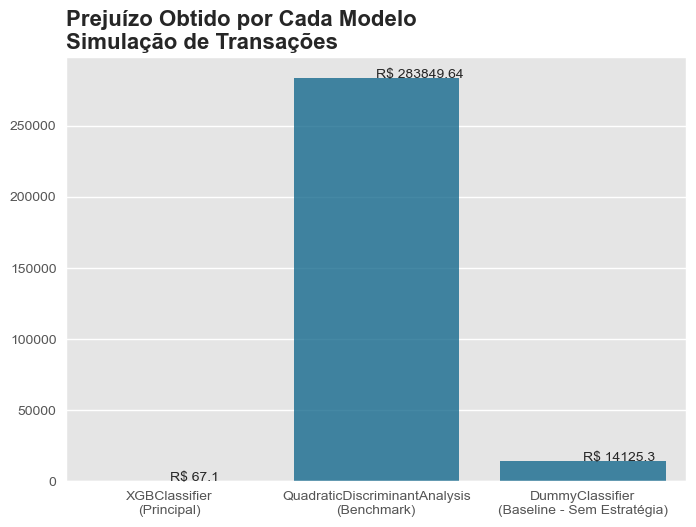

In [217]:
models_names = [
    f'{xgb.__class__.__name__}\n(Principal)',
    f'{bench.__class__.__name__}\n(Benchmark)',
    f'{dummy.__class__.__name__}\n(Baseline - Sem Estratégia)'
]

models_amounts = [
    amount_xgb,
    amount_bench,
    amount_dummy
]

plt.style.use('ggplot')

sns.barplot(
    x=models_names,
    y=models_amounts,
    palette=['b'],
    alpha=.8
);

for x, y in enumerate(models_amounts):
    plt.text(x, y, f'R$ {round(y, 2)}');

plt.title(
    label='Prejuízo Obtido por Cada Modelo\n' \
        'Simulação de Transações',
    fontweight='bold',
    fontsize=16,
    loc='left'
);

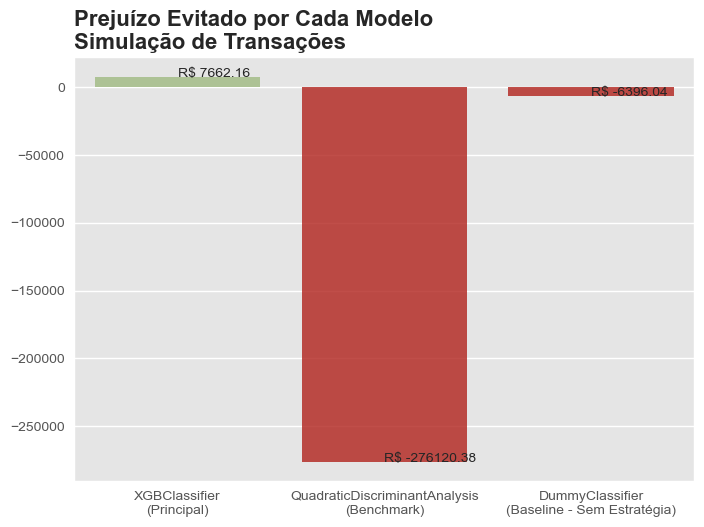

In [212]:
models_profits = [
    fraud_amount - amount_xgb,
    fraud_amount - amount_bench,
    fraud_amount - amount_dummy
]

sns.barplot(
    x=models_names,
    y=models_profits,
    palette=['g','r', 'r'],
    alpha=.8
);

for x, y in enumerate(models_profits):
    plt.text(x, y, f'R$ {round(y, 2)}');

plt.title(
    label='Prejuízo Evitado por Cada Modelo\n' \
        'Simulação de Transações',
    fontweight='bold',
    fontsize=16,
    loc='left'
);

In [193]:
comparison = pd.DataFrame({
    'Numerador': [
        xgb.__class__.__name__,
        xgb.__class__.__name__,
        bench.__class__.__name__,
        bench.__class__.__name__
    ],
    'Denominador': [
        bench.__class__.__name__,
        dummy.__class__.__name__,
        xgb.__class__.__name__,
        dummy.__class__.__name__,
    ],
    'Prejuízo Evitado': [
        fraud_amount - amount_xgb,
        fraud_amount - amount_xgb,
        fraud_amount - amount_bench,
        fraud_amount - amount_bench
    ],
    'Prejuízo Numerador': [
        amount_xgb,
        amount_xgb,
        amount_bench,
        amount_bench
    ],
    'Prejuízo Denominador': [
        amount_bench,
        amount_dummy,
        amount_xgb,
        amount_dummy
    ],
    'Razão': [
        amount_xgb / amount_bench,
        amount_xgb / amount_dummy,
        amount_bench / amount_xgb,
        amount_bench / amount_dummy
    ],
    'Razão^(-1)': [
        round((amount_xgb / amount_bench)**(-1), 4),
        round((amount_xgb / amount_dummy)**(-1), 4),
        round((amount_bench / amount_xgb)**(-1), 4),
        round((amount_bench / amount_dummy)**(-1), 4)
    ]
})

comparison = comparison.set_index([
    'Numerador',
    'Denominador'
])

comparison

Prejuízo Evitado  \
Numerador                     Denominador                                       
XGBClassifier                 QuadraticDiscriminantAnalysis           7662.16   
                              DummyClassifier                         7662.16   
QuadraticDiscriminantAnalysis XGBClassifier                        -276120.38   
                              DummyClassifier                      -276120.38   

                                                             Prejuízo Numerador  \
Numerador                     Denominador                                         
XGBClassifier                 QuadraticDiscriminantAnalysis               67.10   
                              DummyClassifier                             67.10   
QuadraticDiscriminantAnalysis XGBClassifier                           283849.64   
                              DummyClassifier                         283849.64   

                                                             Prejuízo Denominador  \
Numerador                     Denominador                                           
XGBClassifier                 QuadraticDiscriminantAnalysis             283849.64   
                              DummyClassifier                            14125.30   
QuadraticDiscriminantAnalysis XGBClassifier                                 67.10   
                              DummyClassifier                            14125.30   

                                                                   Razão  \
Numerador                     Denominador                                  
XGBClassifier                 QuadraticDiscriminantAnalysis     0.000236   
                              DummyClassifier                   0.004750   
QuadraticDiscriminantAnalysis XGBClassifier                  4230.247988   
                              DummyClassifier                  20.095123   

                                                             Razão^(-1)  
Numerador                     Denominador                                
XGBClassifier                 QuadraticDiscriminantAnalysis   4230.2480  
                              DummyClassifier                  210.5112  
QuadraticDiscriminantAnalysis XGBClassifier                      0.0002  
                              DummyClassifier                    0.0498

## Conclusão

In [187]:
amount_dummy - amount_xgb

14058.199999999999

In [188]:
amount_dummy / amount_xgb

210.51117734724292

O nosso modelo evitou a perda de R$ 14058,19, representando um desempenho cerca de 210,5 vezes maior que a ausência de estratégia (modelo `Dummy`).